# An example of fitting the synthetic nascent signal data

In [1]:
using CSV, DataFrames
using Plots; theme(:vibrant)
using RNAInferenceTool, StatsBase

## Import data and load SSA functions

In [2]:
# Import SSA code install delay SSA package at https://github.com/palmtree2013/DelaySSAToolkit.jl
include("delaytelegraphSSA.jl")
# Parameters 
τ = 0.5
tf = 20 
params = [1.0526,8.2034,57.989,0,0,τ,tf] # σ_off, σ_on, ρ_on, ρ_off, d, τ, SSA final time
L1 = 862; L = 3062; # L1 =  signal fluorescence 862 bp; L = total gene 3062 bp 

3062

## Generate synthetic SSA signal data

In [3]:
numofRun = 10000 # delay SSA sample size
djprob = construct_prob_delaytelegraph(params)
ens_prob = EnsembleProblem(djprob)
ens = solve(ens_prob, SSAStepper(), EnsembleSerial(), trajectories = numofRun);

## Check the distribution

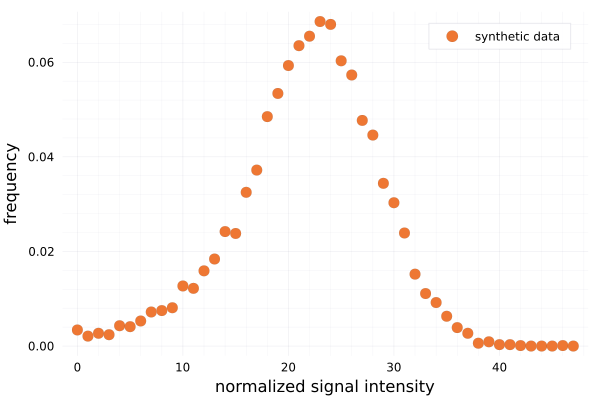

In [18]:
filter_pos_tf = [ens[i].channel[end][1] for i in eachindex(ens)]
res_ens = [signal_function.(filter_pos_tf[i], τ = τ, L1 = L1, L = L) for i in eachindex(filter_pos_tf)]
histo_synthetic = sum_with_non.(res_ens)
scatter(convert_histo(histo_synthetic), labels="synthetic data", xlabel = "normalized signal intensity", ylabel = "frequency") # plot distribution
# savefig("syntheticdata.svg")

 # Inference

## load functions and set parameters

In [5]:
#For delay model the parameter order: σ_off, σ_on, ρ_on, ρ_off, d, τ
SRange = [(0.0,50.0),(0.0,50.0),(0.0,100.0),(0.0,0.0),(0.0,0.0),(τ,τ)];

#For telegraph model the parameter order: σ_off, σ_on, ρ_on, ρ_off, d
SRange_tele = [(0.0,50.0),(0.0,50.0),(0.0,100.0),(0.0,0.0),(1/τ,1/τ)];

Next, we set the data structure for inference `OptimStruct`, which consists of the following elements:

1. data: default type is histogram data (in this work and the following demo, we used this type of data); the other additional supported type is to use probability distribution.
2. stage: `G1()` or `G2()`; where `G2()` type data is inferred by convolution of two G1 stage distribution.
3. dist: the distance function: `Likelihood()`, `Likelihood_fusion()`, `Likelihood_rejection()` and other distance functions in Distances.jl package are supported.
4. model: telegraph model `Telegraph()`, delay telegraph model `Delay()`, and Poisson model `Poisson()` are supported.
   
Keywords arguments:
1. infer_counts: Bool type, `true` if the inferred histogram data is the product count (e.g. the number of Pol II attached to the gene), `false` if the histogram data is the normalized signal intensity (e.g. signal affected by the PP7 Loop).
2. L1 and L2: if `infer_counts` is set to `false` then L1 and L2 must be provided which represents the respective length of the linear part and plateau part of the trapezoid signal function respectively.

In [6]:
infer_struct = OptimStruct(histo_synthetic, G1(), Likelihood(), Delay(); infer_counts = false, L1 = 862, L2 =2200)
infer_struct_tele = OptimStruct(histo_synthetic, G1(), Likelihood(), Telegraph(); infer_counts = false, L1 = 862, L2 =2200)

OptimStruct{G1, Likelihood, Telegraph, Int64}([23.381683327825467, 28.429284568263668, 27.278444776527568, 14.280632242148002, 25.761558401804578, 23.48106253312787, 10.0, 22.320061898564568, 35.58933154952806, 17.082005608735294  …  16.291841311105028, 18.0, 25.166227941118976, 21.02505228275568, 18.66861960908089, 19.429258632518938, 16.0, 27.60848771384817, 6.252205176134538, 17.85542286860793], G1(), Likelihood(), Telegraph(), true, false, 862, 2200)

In [7]:
estimated_params, distributions = optim_function(SRange, infer_struct, MaxFuncEvals = 10000)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.51 secs, 96 evals, 55 steps

, improv/step: 0.436 (last = 0.4364), fitness=33395.738002184


1.01 secs, 182 evals, 117 steps, improv/step: 0.419 (last = 0.4032), fitness=33395.738002184
1.51 secs, 299 evals, 229 steps

, improv/step: 0.380 (last = 0.3393), fitness=33304.373905349


2.01 secs, 429 evals, 369 steps, improv/step: 0.320 (last = 0.2214), fitness=33304.373905349
2.52 secs, 556 evals, 512 steps

, improv/step: 0.303 (last = 0.2587), fitness=32878.607702202


3.02 secs, 678 evals, 645 steps, improv/step: 0.279 (last = 0.1880), fitness=32878.607702202
3.52 secs, 804 evals, 782 steps

, improv/step: 0.263 (last = 0.1898), fitness=32878.607702202


4.03 secs, 929 evals, 925 steps, improv/step: 0.242 (last = 0.1259), fitness=32795.570503947
4.53 secs, 1053 evals, 1068 steps

, improv/step: 0.228 (last = 0.1329), fitness=32788.957554265


5.03 secs, 1184 evals, 1220 steps, improv/step: 0.212 (last = 0.1053), fitness=32788.957554265
5.53 secs, 1312 evals, 1371 steps

, improv/step: 0.204 (last = 0.1391), fitness=32788.957554265


6.04 secs, 1439 evals, 1516 steps, improv/step: 0.195 (last = 0.1103), fitness=32763.162983533
6.54 secs, 1568 evals, 1656 steps

, improv/step: 0.197 (last = 0.2143), fitness=32763.162983533


7.04 secs, 1692 evals, 1797 steps, improv/step: 0.195 (last = 0.1773), fitness=32746.204667010
7.55 secs, 1825 evals, 1953 steps

, improv/step: 0.192 (last = 0.1538), fitness=32741.119353562


8.05 secs, 1954 evals, 2095 steps, improv/step: 0.194 (last = 0.2183), fitness=32741.119353562
8.55 secs, 2080 evals, 2236 steps

, improv/step: 0.192 (last = 0.1702), fitness=32741.119353562


9.05 secs, 2210 evals, 2389 steps, improv/step: 0.194 (last = 0.2222), fitness=32738.455835582
9.55 secs, 2335 evals, 2531 steps

, improv/step: 0.192 (last = 0.1620), fitness=32738.455835582


10.06 secs, 2458 evals, 2674 steps, improv/step: 0.195 (last = 0.2378), fitness=32738.455835582
10.56 secs, 2576 evals, 2806 steps

, improv/step: 0.192 (last = 0.1439), fitness=32738.116704202


11.06 secs, 2689 evals, 2938 steps, improv/step: 0.194 (last = 0.2348), fitness=32737.750213066
11.56 secs, 2811 evals, 3078 steps

, improv/step: 0.193 (last = 0.1643), fitness=32737.750213066


12.06 secs, 2942 evals, 3225 steps, improv/step: 0.196 (last = 0.2653), fitness=32737.750213066
12.57 secs, 3064 evals, 3357 steps

, improv/step: 0.198 (last = 0.2348), fitness=32737.743827721


13.07 secs, 3193 evals, 3504 steps, improv/step: 0.195 (last = 0.1429), fitness=32737.743827721
13.57 secs, 3302 evals, 3624 steps

, improv/step: 0.195 (last = 0.1833), fitness=32737.743827721


14.07 secs, 3422 evals, 3759 steps, improv/step: 0.197 (last = 0.2444), fitness=32737.736141066
14.58 secs, 3551 evals, 3904 steps

, improv/step: 0.195 (last = 0.1517), fitness=32737.713501145


15.08 secs, 3675 evals, 4041 steps, improv/step: 0.197 (last = 0.2409), fitness=32737.708981963
15.58 secs, 3803 evals, 4180 steps

, improv/step: 0.199 (last = 0.2518), fitness=32737.707771929


16.08 secs, 3919 evals, 4310 steps, improv/step: 0.200 (last = 0.2615), fitness=32737.705328915
16.59 secs, 4028 evals, 4435 steps

, improv/step: 0.200 (last = 0.1840), fitness=32737.705281833


17.09 secs, 4128 evals, 4546 steps, improv/step: 0.199 (last = 0.1712), fitness=32737.705281833
17.59 secs, 4220 evals, 4651 steps

, improv/step: 0.200 (last = 0.2476), fitness=32737.705010736


18.09 secs, 4335 evals, 4784 steps, improv/step: 0.201 (last = 0.2256), fitness=32737.704320620
18.59 secs, 4442 evals, 4905 steps

, improv/step: 0.201 (last = 0.1983), fitness=32737.704282990


19.09 secs, 4545 evals, 5025 steps, improv/step: 0.200 (last = 0.1417), fitness=32737.704050163
19.59 secs, 4608 evals, 5098 steps

, improv/step: 0.200 (last = 0.2055), fitness=32737.704009090


20.09 secs, 4699 evals, 5200 steps, improv/step: 0.201 (last = 0.2549), fitness=32737.704009090
20.60 secs, 4789 evals, 5305 steps

, improv/step: 0.202 (last = 0.2667), fitness=32737.704009090


21.10 secs, 4859 evals, 5379 steps, improv/step: 0.203 (last = 0.2432), fitness=32737.704009090
21.60 secs, 4972 evals, 5507 steps

, improv/step: 0.202 (last = 0.1875), fitness=32737.704001503


22.10 secs, 5032 evals, 5573 steps, improv/step: 0.202 (last = 0.1818), fitness=32737.704001503
22.61 secs, 5114 evals, 5669 steps

, improv/step: 0.201 (last = 0.1667), fitness=32737.703942435


23.14 secs, 5219 evals, 5790 steps, improv/step: 0.202 (last = 0.2149), fitness=32737.703942435
23.67 secs, 5230 evals, 5803 steps

, improv/step: 0.202 (last = 0.1538), fitness=32737.703942435


24.17 secs, 5329 evals, 5911 steps, improv/step: 0.201 (last = 0.1667), fitness=32737.703937993
24.67 secs, 5445 evals, 6043 steps

, improv/step: 0.202 (last = 0.2348), fitness=32737.703937800


25.18 secs, 5550 evals, 6165 steps, improv/step: 0.201 (last = 0.1803), fitness=32737.703935271
25.68 secs, 5655 evals, 6283 steps

, improv/step: 0.201 (last = 0.2119), fitness=32737.703935271


26.18 secs, 5769 evals, 6412 steps, improv/step: 0.201 (last = 0.1860), fitness=32737.703933702
26.68 secs, 5888 evals, 6551 steps

, improv/step: 0.200 (last = 0.1655), fitness=32737.703933702


27.18 secs, 6010 evals, 6688 steps, improv/step: 0.202 (last = 0.2920), fitness=32737.703932377
27.68 secs, 6125 evals, 6816 steps

, improv/step: 0.203 (last = 0.2266), fitness=32737.703932377


28.19 secs, 6246 evals, 6958 steps, improv/step: 0.202 (last = 0.1620), fitness=32737.703932307
28.70 secs, 6300 evals, 7023 steps

, improv/step: 0.203 (last = 0.3077), fitness=32737.703931760


29.20 secs, 6378 evals, 7112 steps, improv/step: 0.203 (last = 0.1798), fitness=32737.703931495
29.70 secs, 6502 evals, 7251 steps

, improv/step: 0.203 (last = 0.2014), fitness=32737.703931361


30.20 secs, 6606 evals, 7364 steps, improv/step: 0.203 (last = 0.2389), fitness=32737.703931352
30.71 secs, 6708 evals, 7477 steps

, improv/step: 0.203 (last = 0.2124), fitness=32737.703931350


31.21 secs, 6810 evals, 7590 steps, improv/step: 0.203 (last = 0.2124), fitness=32737.703931350
31.71 secs, 6939 evals, 7735 steps

, improv/step: 0.204 (last = 0.2138), fitness=32737.703931337


32.21 secs, 7075 evals, 7889 steps, improv/step: 0.204 (last = 0.2338), fitness=32737.703931325
32.72 secs, 7206 evals, 8041 steps

, improv/step: 0.205 (last = 0.2566), fitness=32737.703931322


33.22 secs, 7334 evals, 8187 steps, improv/step: 0.206 (last = 0.2397), fitness=32737.703931322
33.72 secs, 7467 evals, 8339 steps

, improv/step: 0.206 (last = 0.1974), fitness=32737.703931322


34.22 secs, 7594 evals, 8480 steps, improv/step: 0.206 (last = 0.2411), fitness=32737.703931320
34.73 secs, 7726 evals, 8625 steps

, improv/step: 0.207 (last = 0.2276), fitness=32737.703931320


35.23 secs, 7855 evals, 8769 steps, improv/step: 0.206 (last = 0.1736), fitness=32737.703931319
35.73 secs, 7983 evals, 8916 steps

, improv/step: 0.206 (last = 0.2245), fitness=32737.703931319


36.23 secs, 8111 evals, 9059 steps, improv/step: 0.206 (last = 0.2028), fitness=32737.703931319
36.73 secs, 8242 evals, 9197 steps

, improv/step: 0.206 (last = 0.2174), fitness=32737.703931319


37.24 secs, 8365 evals, 9334 steps, improv/step: 0.206 (last = 0.1825), fitness=32737.703931319
37.74 secs, 8486 evals, 9473 steps

, improv/step: 0.206 (last = 0.2014), fitness=32737.703931319


38.24 secs, 8606 evals, 9614 steps, improv/step: 0.206 (last = 0.1915), fitness=32737.703931319
38.74 secs, 8724 evals, 9753 steps

, improv/step: 0.205 (last = 0.1799), fitness=32737.703931319


39.24 secs, 8843 evals, 9885 steps, improv/step: 0.205 (last = 0.1667), fitness=32737.703931319
39.75 secs, 8962 evals, 10026 steps

, improv/step: 0.204 (last = 0.1277), fitness=32737.703931319


40.25 secs, 9080 evals, 10156 steps, improv/step: 0.203 (last = 0.1077), fitness=32737.703931319
40.75 secs, 9201 evals, 10289 steps

, improv/step: 0.202 (last = 0.1203), fitness=32737.703931319


41.26 secs, 9307 evals, 10411 steps, improv/step: 0.201 (last = 0.1230), fitness=32737.703931319
41.76 secs, 9420 evals, 10538 steps

, improv/step: 0.200 (last = 0.1102), fitness=32737.703931319


42.26 secs, 9547 evals, 10686 steps, improv/step: 0.198 (last = 0.0541), fitness=32737.703931319
42.76 secs, 9672 evals, 10831 steps

, improv/step: 0.196 (last = 0.0828), fitness=32737.703931319


43.28 secs, 9786 evals, 10964 steps, improv/step: 0.195 (last = 0.0752), fitness=32737.703931319
43.78 secs, 9894 evals, 11090 steps

, improv/step: 0.193 (last = 0.0556), fitness=32737.703931319



Optimization stopped after 11216 steps and 44.25 seconds
Termination reason: Max number of function evaluations (10000) reached
Steps per second = 253.50
Function evals per second = 226.04
Improvements/step = Inf
Total function evaluations = 10001


Best candidate found: [0.909388, 7.43797, 57.942, 0.0, 0.0, 0.5]

Fitness: 32737.703931319



([0.9093877852062164, 7.437972487551714, 57.942023905843755, 0.0, 0.0, 0.5, 32737.703931319156], [0.004120487980449976 0.0034; 0.0018583592049153772 0.0021; … ; 4.700069026756239e-10 0.0; 2.0091119002486645e-11 0.0])

In [8]:
estimated_params_tele, distributions_tele = optim_function(SRange_tele, infer_struct_tele, MaxFuncEvals = 10000)

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64}, BlackBoxOptim.RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, BlackBoxOptim.RandomBound{BlackBoxOptim.ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 1992 evals, 2082 steps

, improv/step: 0.177 (last = 0.1772), fitness=32804.446508681


1.00 secs, 4019 evals, 4329 steps, improv/step: 0.186 (last = 0.1940), fitness=32750.719341581
1.50 secs, 6159 evals, 6693 steps

, improv/step: 0.200 (last = 0.2255), fitness=32750.714085220


2.00 secs, 8281 evals, 9046 steps, improv/step: 0.204 (last = 0.2146), fitness=32750.714083381

Optimization stopped after 10956 steps and 2.40 seconds


Termination reason: Max number of function evaluations (10000) reached
Steps per second = 4561.51
Function evals per second = 4163.89
Improvements/step = Inf
Total function evaluations = 10001


Best candidate found: [0.407169, 3.21838, 58.12, 0.0, 2.0]

Fitness: 32750.714083381



([0.4071690812574138, 3.2183759431851886, 58.11996232964187, 0.0, 2.0, 32750.71408338093], [0.00150601127231075 0.0034; 0.0024106803878977756 0.0021; … ; 4.4712967431627255e-10 0.0; 1.9126595406295793e-11 0.0])

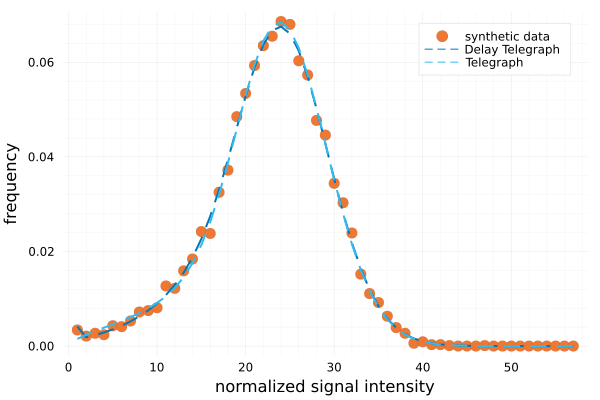

In [16]:
scatter(distributions[:,2],labels="synthetic data", xlabel = "normalized signal intensity", ylabel = "frequency")
plot!([distributions[:,1] distributions_tele[:,1]],lines=(2, :dash),labels=["Delay Telegraph" "Telegraph"])
# savefig("delaytele.svg")

In [10]:
#Compare the paramters
DataFrame(True = params[1:3],Delay=estimated_params[1:3],Telegraph= estimated_params_tele[1:3])

,True,Delay,Telegraph
,Float64,Float64,Float64
1,1.0526,0.909388,0.407169
2,8.2034,7.43797,3.21838
3,57.989,57.942,58.12
